# MLP by numpy

用numpy实现一个NN

In [77]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

## 0. 数据

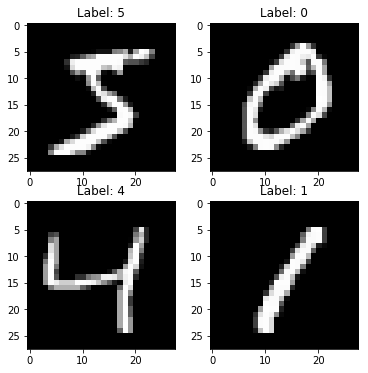

In [78]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');



## 1. 设计 Layer

In [79]:
class Layer:
    def __init__(self):
        # no parameters
        pass
    
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Dense

In [136]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        # xavier : http://bit.ly/2vTlmaJ
        self.W = np.random.randn(input_units, output_units) * 0.01
        self.b = np.zeros(output_units)
        
    def forward(self, X):
        return np.dot(X, self.W) + self.b
    
    def backward(self, X, dY):        
        # use dim to calcualte
        dX = np.dot(dY, self.W.T)
        
        # no 1/ m here, why???
        dW = np.dot(X.T, dY)
        db = np.sum(dY, axis=0)
        
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
        
        return dX

### ReLU

In [144]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, X):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(X, 0)
    
    def backward(self, X, dY):
        """Compute gradient of loss w.r.t. ReLU input"""
        return dY * (X > 0)

### The loss function

#### softmax
计算公式
$$ p_i = \frac{e^{a_i}}{\sum_k^{n\_classes}{e^{a_k}}}$$
如果需要数值稳定性，需要同时除以 $e^{a_{max}}$


#### cross-entropy
先看一个样本的 cross-entropy
$$ H(y, p) = - \sum_c^{n\_classes}y_c \log{p_c} = - \log{p_{c'}}$$
其中 $c'$ 是 $y_{c'} = 1$ 的那个 。

如果多个样本：
$$ H(y, p) = - \frac{1}{m} \sum_i \log{p_{c'}} $$

#### derivative of cross-entropy

有两个导数：

- loss相对于 softmax输出的导数
- loss相对于 softmax输入的导数

其实后者的形式更简单：
$$L = - \sum_c^{n\_classes}y_c \log{p_c} \\ \space
\frac{\partial L}{\partial a_i} = p_i - y_i$$


In [145]:
def softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps, axis=-1, keepdims=True)

def softmax_crossentropy_with_logits(logits, y):
    m = y.shape[0]
    p = softmax(logits)
    log_likelihood = -np.log(p[range(m), y])  # 每个样本，选择正确的那个p，输出(m,)
    loss = np.sum(log_likelihood) / m
    return loss

def grad_softmax_crossentropy_with_logits(logits, y):
    m = y.shape[0]
    grad = softmax(logits)
    grad[range(m), y] -= 1  # 用了一点技巧，这里y是labels，只对y 减 1， 其他相当于减 0
    return grad / m

In [146]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

from util import eval_numerical_gradient
softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

## 2. 设计 MLP


In [147]:
from tqdm import trange

def next_batch(X, y, batch_size, shuffle=False):
    assert len(X) == len(y)
    if shuffle:
        indices = np.random.permutation(len(X))
    for i in trange(0, len(X) - batch_size + 1, batch_size):
        if shuffle:
            idx = indices[i : i + batch_size]
        else:
            idx = slice(i, i + batch_size)
        yield X[idx], y[idx]

In [155]:

class Model(object):
    def __init__(self):
        self.network = []
        self.history = {}
    
    def add(self, layer):
        """like keras sequential"""
        self.network.append(layer)
        
#     def compile(self, loss_func, grad_loss_func):
#         """set loss fucntion, gradient, like keras model..."""
#         pass

    def init_paramters(self, method=None):
        for layer in self.network:
            if layer.__class__.__name__ == 'Dense':
                shape = layer.W.shape
                if method == 'xavier':
                    layer.W = np.random.randn(*shape) * np.sqrt(1. / shape[0])
                else:
                    layer.W = np.random.randn(*shape)
    
    def forward(self, X):
        activations = []
        _X = X
        for layer in self.network:
            _X = layer.forward(_X)
            activations.append(_X)
#         assert len(activations) == len(network)
        return activations
    
    def predict(self, X):
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)
    
    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)
    
    def optimize(self, X, y):
        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
        logits = layer_activations[-1]

        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits,y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

        grad_output = loss_grad
        num_layers = len(self.network)
        for i in range(num_layers - 1, -1, -1):
            layer = self.network[i]
            layer_input = layer_inputs[i]
            grad_output = layer.backward(layer_input, grad_output)
        return np.mean(loss)
    
    def train(self, X_train, y_train, validation_data, epochs=25, batch_size=32, shuffle=True):
        
        train_log = self.history.get('train_log', [])
        val_log = self.history.get('val_log', [])
        
        X_val, y_val = validation_data
        
        last_epoch = len(train_log)
        
        for epoch in range(last_epoch, last_epoch + epochs):
            for x_batch, y_batch in next_batch(X_train, y_train, batch_size=batch_size, shuffle=shuffle):
                self.optimize(x_batch, y_batch)
                
            train_log.append(self.accuracy(X_train, y_train))
            val_log.append(self.accuracy(X_val, y_val))

            clear_output(wait=True)
            print("Epoch",epoch)
            print("Train accuracy:",train_log[-1])
            print("Val accuracy:",val_log[-1])

            plt.plot(train_log, label="Train Acc")
            plt.plot(val_log, label="Val Acc")
            plt.legend(loc='best')
            plt.xlabel('Iterations')
            plt.ylabel('Percent (%)')
            plt.show()
        self.history['train_log'] = train_log
        self.history['val_log'] = val_log
        

In [175]:
def create_mlp_model(layers, activation=ReLU):
    model = Model()
    for i in range(len(layers)-2):
        model.add(Dense(layers[i], layers[i+1]))
        model.add(activation())
    model.add(Dense(layers[-2], layers[-1]))
    return model

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9813


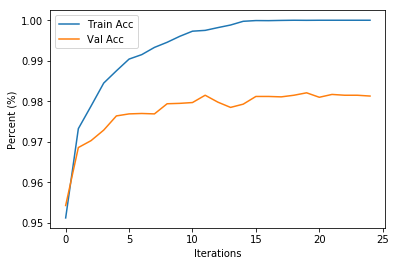

In [176]:
model = create_mlp_model([X_train.shape[1], 100, 200, 10])
model.init_paramters(method='xavier')
model.train(X_train, y_train, (X_val, y_val))

In [159]:
model.accuracy(X_test, y_test)

0.981


## 3. Initialization

Implement Dense layer with Xavier initialization as explained [here](http://bit.ly/2vTlmaJ)

Epoch 13
Train accuracy: 0.99984
Val accuracy: 0.9828


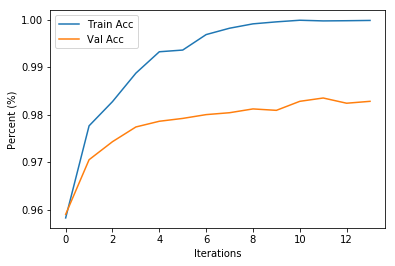

  6%|▌         | 94/1562 [00:00<00:03, 461.90it/s]

In [ ]:
model = create_mlp_model([X_train.shape[1], 500, 300, 10])
model.init_paramters(method='xavier')
model.train(X_train, y_train, (X_val, y_val))

In [ ]:
model = create_mlp_model([X_train.shape[1], 500, 300, 10])
model.init_paramters()
model.train(X_train, y_train, (X_val, y_val))


## 4. Regularization

### Peer-reviewed assignment

Congradulations, you managed to get this far! There is just one quest left undone, and this time you'll get to choose what to do.


#### Option I: initialization
* Implement Dense layer with Xavier initialization as explained [here](http://bit.ly/2vTlmaJ)

To pass this assignment, you must conduct an experiment showing how xavier initialization compares to default initialization on deep networks (5+ layers).


#### Option II: regularization
* Implement a version of Dense layer with L2 regularization penalty: when updating Dense Layer weights, adjust gradients to minimize

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

To pass this assignment, you must conduct an experiment showing if regularization mitigates overfitting in case of abundantly large number of neurons. Consider tuning $\alpha$ for better results.

#### Option III: optimization
* Implement a version of Dense layer that uses momentum/rmsprop or whatever method worked best for you last time.

Most of those methods require persistent parameters like momentum direction or moving average grad norm, but you can easily store those params inside your layers.

To pass this assignment, you must conduct an experiment showing how your chosen method performs compared to vanilla SGD.

### General remarks
_Please read the peer-review guidelines before starting this part of the assignment._

In short, a good solution is one that:
* is based on this notebook
* runs in the default course environment with Run All
* its code doesn't cause spontaneous eye bleeding
* its report is easy to read.

_Formally we can't ban you from writing boring reports, but if you bored your reviewer to death, there's noone left alive to give you the grade you want._


### Bonus assignments

As a bonus assignment (no points, just swag), consider implementing Batch Normalization ([guide](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)) or Dropout ([guide](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)). Note, however, that those "layers" behave differently when training and when predicting on test set.

* Dropout:
  * During training: drop units randomly with probability __p__ and multiply everything by __1/(1-p)__
  * During final predicton: do nothing; pretend there's no dropout
  
* Batch normalization
  * During training, it substracts mean-over-batch and divides by std-over-batch and updates mean and variance.
  * During final prediction, it uses accumulated mean and variance.
